Loading Data and Preprocessing

In [1]:
import os
import torch
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torch.utils.data import DataLoader

# Define transforms for data preprocessing
transform = transforms.Compose([
    transforms.Resize((256, 256)),   # Resize images to 256x256
    transforms.ToTensor(),            # Convert images to tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize image tensors
])

# Define the path to the test dataset
test_data_dir = "data"

# Create dataset from ImageFolder for the test data
test_dataset = ImageFolder(root=test_data_dir, transform=transform)

# Create a DataLoader for the test data
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Test set:
Class distribution: {0: 0.3215747417657377, 1: 0.013837458585071136, 2: 0.1296043656207367, 3: 0.10017540440459949, 4: 0.005262132137984798, 5: 0.020853634769050867, 6: 0.1296043656207367, 7: 0.15045800038978757, 8: 0.12862989670629507}


Predicting on test data and calculating the accuracy

In [7]:
import torch
import torch.nn as nn
from torchvision import models

# Define the CNN model
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.base_model = models.resnet18(pretrained=True)
        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, num_classes)

    def forward(self, x):
        return self.base_model(x)

# Load the saved model
saved_model_path = "best_model_1.pth"
num_classes = 9  # Update with the number of classes in your dataset
model = CustomCNN(num_classes)
model.load_state_dict(torch.load(saved_model_path))
model.eval()

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the appropriate device
model.to(device)

# Define a function to calculate accuracy
def calculate_accuracy(model, dataloader, device):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# Calculate accuracy on the test data
test_accuracy = calculate_accuracy(model, test_loader, device)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Test Accuracy: 98.66%


Computing the evaluation metrics

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1650
           1       0.99      0.99      0.99        71
           2       0.97      0.97      0.97       665
           3       0.99      0.99      0.99       514
           4       0.96      0.89      0.92        27
           5       1.00      1.00      1.00       107
           6       0.98      0.99      0.98       665
           7       0.99      1.00      0.99       772
           8       0.98      0.97      0.98       660

    accuracy                           0.99      5131
   macro avg       0.98      0.98      0.98      5131
weighted avg       0.99      0.99      0.99      5131



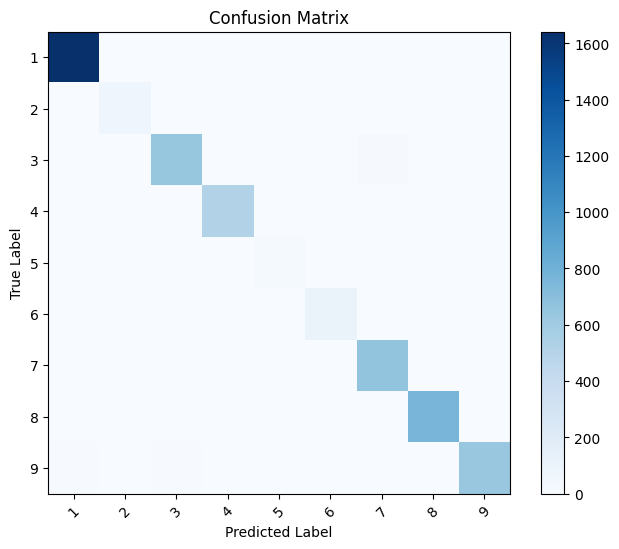

In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Function to calculate evaluation metrics
def evaluate_model_metrics(model, test_loader, device):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Convert to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Classification Report
    print("Classification Report:")
    print(classification_report(y_true, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    num_classes = len(test_loader.dataset.classes)
    plt.xticks(np.arange(num_classes), test_loader.dataset.classes, rotation=45)
    plt.yticks(np.arange(num_classes), test_loader.dataset.classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Evaluate model metrics
evaluate_model_metrics(model, test_loader, device)
